# (let the bot generate this desc)

Imports:

In [ ]:
try:
    import sys
    import os
    import requests
    from zipfile import ZipFile
    from tqdm import tqdm
    import numpy as np
    from numpy.linalg import norm
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    from sklearn.cluster import KMeans
    from gensim.test.utils import datapath, get_tmpfile
    from gensim.models import KeyedVectors
    from gensim.scripts.glove2word2vec import glove2word2vec
    import networkx as nx

except ImportError:
    sys.exit("""You are missing necessary Python libraries!
    Run the installation chunck.""")

import warnings; warnings.simplefilter('ignore')

plt.style.use('ggplot')

**Installation chunk** (uncomment necessary commands)

In [ ]:
# %pip install numpy
# %pip install matplotlib
# %pip install sklearn
# %pip install gensim
# %pip install requests
# %pip install zipfile

**Load the necessary files** (it'll download if necessary)

(for future commits: see if line `word_vectors = api.load("glove-wiki-gigaword-100")` from [here](https://radimrehurek.com/gensim/models/keyedvectors.html) does a better job for both this NB and maybe a Colab NB as well)

In [2]:
# This function downloads a file from "url" and presents a progress bar:
def download_file(url, glove_file):
    r = requests.get(url, stream=True, allow_redirects=True)
    total_size = int(r.headers.get('content-length'))
    initial_pos = 0
    with open(glove_file,'wb') as f: 
        with tqdm(total=total_size,
                  unit='B',
                  unit_scale=True,                      
                  desc=glove_file,initial=initial_pos, ascii=True) as pbar:
          for ch in r.iter_content(chunk_size=1024):                             
                  if ch:
                      f.write(ch) 
                      pbar.update(len(ch))

# Setting up paths:
folder_for_glove = os.getcwd() + os.sep + 'glove' + os.sep
glove_file = datapath(folder_for_glove + 'glove.6B.100d.txt')
url_for_zip = "https://nlp.stanford.edu/data/glove.6B.zip"
zip_file = datapath(folder_for_glove + url_for_zip.split('/')[-1])

# Check whether glove file exists in the envorironment, if not, download it:
does_glove_file_exist = os.path.exists(glove_file)
if does_glove_file_exist == False:
    # This means we'll need to download the zipped files and unzip them to the necessary folder:
    # Check folder exists:
    does_glove_folder_exist = os.path.exists(folder_for_glove)
    if does_glove_folder_exist == False:
        # Create a folder for glove:
        os.mkdir(folder_for_glove)
                 
    # Download zipped files:
    print("Downloading the zip file from:   " + url_for_zip)
    zip_file0 = download_file(url_for_zip, zip_file)

    # Extract files:
    with ZipFile(zip_file, 'r') as zipObj:
        print("Extracting glove files from the zipped file.")
        zipObj.extractall(folder_for_glove)
        print("Done extracting.")
else:
    print("Successfully located necessary glove file.")
        

Successfully located necessary glove file.


**Load necessary word embeddings**

In [3]:
word2vec_glove_file = get_tmpfile("glove.6B.100d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)

(400000, 100)

### Similarity search with GLOVE word embedding

In [ ]:
# Load pre-trained embeddings (make sure you have a compatible file)
model = KeyedVectors.load_word2vec_format(word2vec_glove_file, binary=False)

def analogy(positive, negative=None, topn=5):
    negative = negative or []
    result = model.most_similar(positive=positive, negative=negative, topn=topn)
    for word, score in result:
        print(f"{word:15s} (score: {score:.4f})")

# Example usage:
print("Analogy with ['c++'] as positive:")
analogy(positive=['c++'])
print("\nAnalogy with 'linkedin':")
analogy(positive=['linkedin'])


Analogy with ['c++'] as positive:
compiler        (score: 0.7527)
fortran         (score: 0.7298)
compilers       (score: 0.7107)
javascript      (score: 0.6958)
objective-c     (score: 0.6713)

Analogy with 'linkedin':
friendster      (score: 0.7622)
myspace         (score: 0.7512)
myspace.com     (score: 0.7366)
facebook        (score: 0.7189)
pinterest       (score: 0.7188)


### Visualize GLOVE embedding in 2 dimensions using PCA for dimensionality reduction

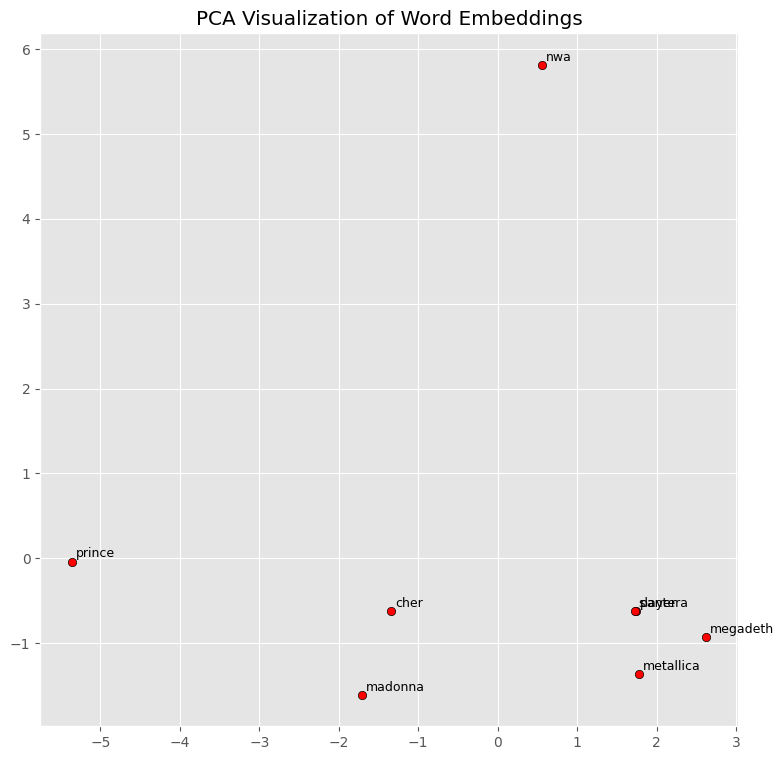

In [22]:
def display_pca_scatterplot(model, words=None, sample=0):
    # Get words: either provided, sampled, or all from the vocabulary.
    if words is None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = list(model.vocab.keys())
            
    vectors = np.array([model[w] for w in words])
    twodim = PCA(n_components=2).fit_transform(vectors)
    
    plt.figure(figsize=(9,9))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x, y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word, fontsize=9)
    plt.title("PCA Visualization of Word Embeddings")
    plt.show()

# Example call:
display_pca_scatterplot(model, 
                        words=['metallica', 'megadeth', 'pantera', 'slayer',
                               'madonna', 'cher', 'nwa', 'prince'])


### Visualize GLOVE embedding in 2 dimensions using tSNE for dimensionality reduction

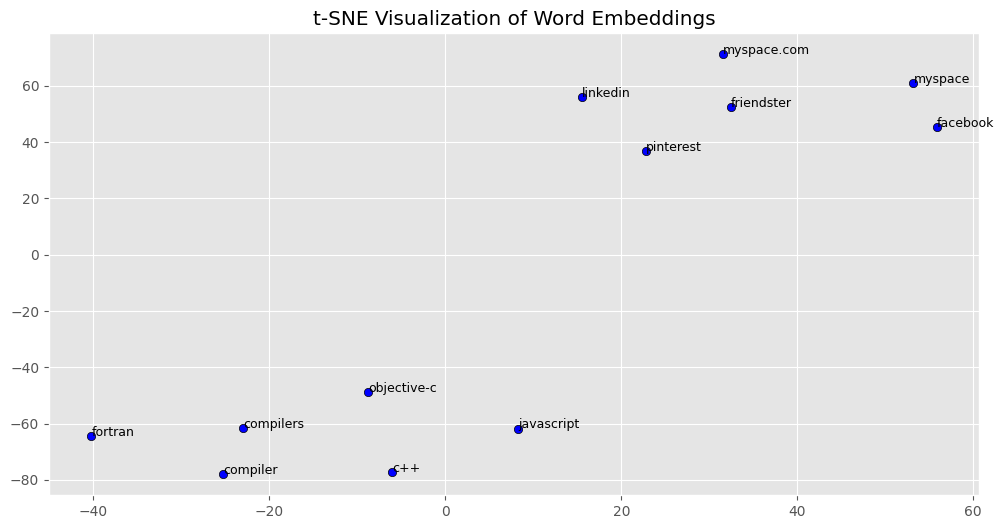

In [24]:

def display_tsne_scatterplot(model, words=None, sample=0):
    if words is None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = list(model.vocab.keys())
            
    vectors = np.array([model[w] for w in words])
    tsne = TSNE(n_components=2, perplexity=5, n_iter=1000, random_state=42)
    twodim = tsne.fit_transform(vectors)
    
    plt.figure(figsize=(12,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='b')
    for word, (x, y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word, fontsize=9)
    plt.title("t-SNE Visualization of Word Embeddings")
    plt.show()

# Example call:
display_tsne_scatterplot(model, words=['c++',
'compiler',
'fortran',
'compilers',
'javascript',
'objective-c',
'linkedin',
'friendster',
'myspace',
'myspace.com',
'facebook',
'pinterest'])




### Explore Cosine similarities between any pair of words in the GLOVE embedding space

In [ ]:
def cosine_similarity(word1, word2, model):
    vec1 = model[word1]
    vec2 = model[word2]
    sim = np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))
    return sim

# Example usage:
word_a = 'king'
word_b = 'queen'
print(f"Cosine similarity between {word_a} and {word_b}: {cosine_similarity(word_a, word_b, model):.4f}")


Cosine similarity between king and queen: 0.7508


### Cluster words based on their embeddings' distance

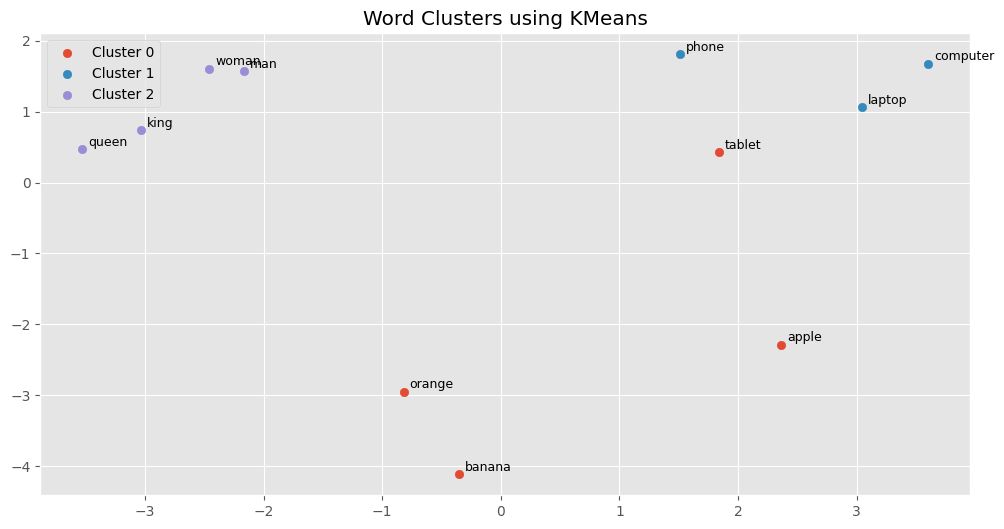

In [29]:
def cluster_words(model, words, n_clusters=4):
    vectors = np.array([model[w] for w in words])
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectors)
    
    # Visualize clusters via PCA:
    twodim = PCA(n_components=2).fit_transform(vectors)
    plt.figure(figsize=(12,6))
    for label in range(n_clusters):
        idxs = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(twodim[idxs,0], twodim[idxs,1], label=f"Cluster {label}")
        for i in idxs:
            plt.text(twodim[i,0]+0.05, twodim[i,1]+0.05, words[i], fontsize=9)
    plt.legend()
    plt.title("Word Clusters using KMeans")
    plt.show()

# Example call:
sample_words = ['king', 'queen', 'man', 'woman', 'apple', 'orange', 'banana', 'computer', 'laptop', 'phone', 'tablet']
cluster_words(model, sample_words, n_clusters=3)


### Apply sentence embedding via work embedding by averaging 

In [30]:
def sentence_embedding(sentence, model):
    words = sentence.lower().split()
    vectors = [model[w] for w in words if w in model]
    if not vectors:
        return None
    return np.mean(vectors, axis=0)

def sentence_similarity(sent1, sent2, model):
    emb1 = sentence_embedding(sent1, model)
    emb2 = sentence_embedding(sent2, model)
    return np.dot(emb1, emb2) / (norm(emb1) * norm(emb2))

# Example usage:
sent1 = "The king rules the kingdom."
sent2 = "The queen governs the realm."
print(f"Sentence similarity: {sentence_similarity(sent1, sent2, model):.4f}")

Sentence similarity: 0.9288


### Semantic Similarity Graph: Build a graph connecting words with edges if their cosine similarity is above a threshold

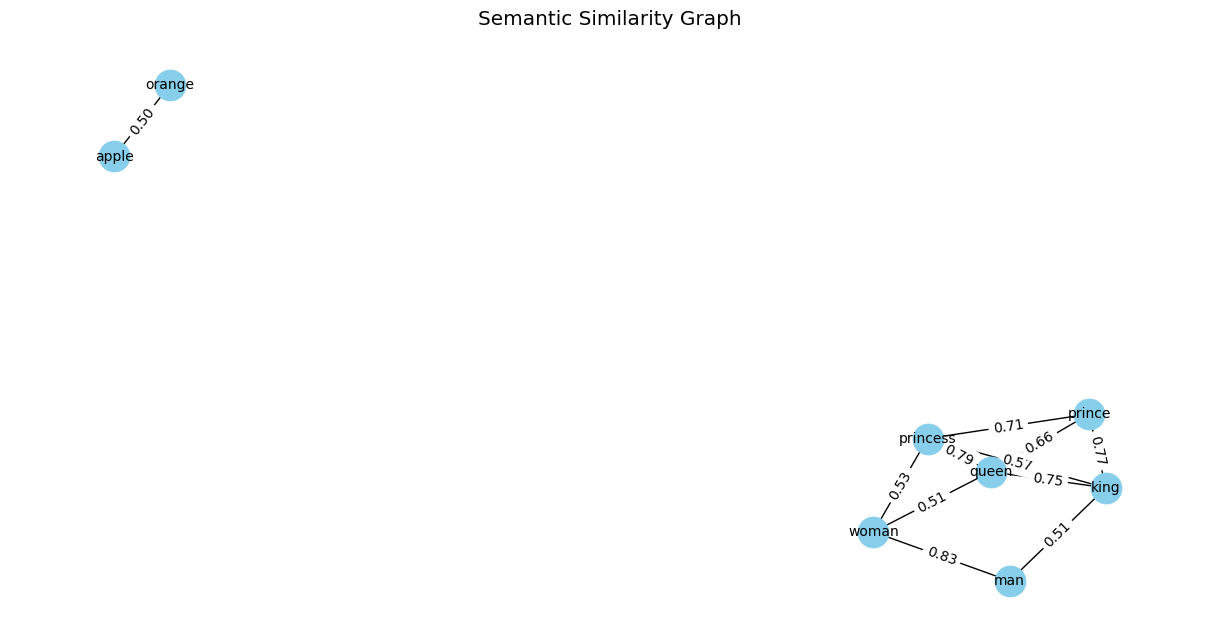

In [ ]:
def build_similarity_graph(model, words, threshold=0.6):
    G = nx.Graph()
    for word in words:
        G.add_node(word)
    
    for i, word1 in enumerate(words):
        for word2 in words[i+1:]:
            sim = cosine_similarity(word1, word2, model)
            if sim > threshold:
                G.add_edge(word1, word2, weight=sim)
    return G

def plot_similarity_graph(G):
    plt.figure(figsize=(12, 6))
    pos = nx.spring_layout(G, k=0.5)
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in labels.items()})
    plt.title("Semantic Similarity Graph")
    plt.show()

# Example:
word_list = ['king', 'queen', 'man', 'woman', 'prince', 'princess', 'apple', 'orange']
G = build_similarity_graph(model, word_list, threshold=0.5)
plot_similarity_graph(G)


### Interactive Word Explorer with ipywidgets

In [38]:
import ipywidgets as widgets
from IPython.display import display

def interactive_neighbors(word):
    if word not in model:
        print(f"Word '{word}' not found in the model!")
        return
    neighbors = model.most_similar(positive=[word], topn=10)
    print(f"Nearest neighbors of '{word}':")
    for neighbor, score in neighbors:
        print(f"{neighbor:15s} (score: {score:.4f})")
    
word_input = widgets.Text(
    value='king',
    description='Word:',
    disabled=False
)

widgets.interact(interactive_neighbors, word=word_input)


interactive(children=(Text(value='king', description='Word:'), Output()), _dom_classes=('widget-interact',))

<function __main__.interactive_neighbors(word)>

### An experiment with next word prediction using embeddings

In [39]:
def generate_story(seed_word, model, steps=15):
    current_word = seed_word
    story = [current_word]
    for _ in range(steps):
        # Find top similar words (exclude the current word to avoid loops)
        similar_words = [w for w, _ in model.most_similar(positive=[current_word], topn=5) if w != current_word]
        if not similar_words:
            break
        # Randomly pick one of the top similar words
        next_word = np.random.choice(similar_words)
        story.append(next_word)
        current_word = next_word
    return " ".join(story)

# Example usage:
story = generate_story("adventure", model, steps=20)
print("Generated Story:")
print(story)


Generated Story:
adventure fiction anthology fiction fantasy epic tale tales fairy godmother cinderella fairy tales stories book novel adaptation novel book story movie
